In [ ]:
%load_ext autoreload
%autoreload 2

# Text: Training Token Classification

> The `text.training.token_classification` module contains the core bits required for training transformers on token classification tasks (e.g., Named entity recognition (NER), Part-of-speech tagging (POS), etc...)

In [ ]:
# |default_exp text.training.token_classification
# |default_cls_lvl 3

In [ ]:
# |export
from __future__ import annotations

import ast, gc, importlib, sys, traceback

from accelerate.logging import get_logger
from dataclasses import dataclass
from dotenv import load_dotenv
from fastai.callback.all import *
from fastai.imports import *
from fastai.learner import *
from fastai.losses import CrossEntropyLossFlat
from fastai.data.block import TransformBlock, Category, CategoryMap
from fastai.metrics import accuracy
from fastai.optimizer import Adam, params
from fastai.data.transforms import TfmdDL
from fastai.text.data import SortedDL
from fastai.torch_core import *
from fastai.torch_imports import *
from seqeval import metrics as seq_metrics
from transformers import (
    AutoConfig,
    AutoTokenizer,
    PretrainedConfig,
    PreTrainedTokenizerBase,
    PreTrainedModel,
    AutoModelForTokenClassification,
)
from transformers import logging as hf_logging
from transformers.data.data_collator import DataCollatorForTokenClassification, DataCollatorWithPadding

from blurr.text.data.core import first_blurr_tfm, get_blurr_tfm, TextDataLoader
from blurr.text.data.token_classification import TokenClassTextInput, get_token_labels_from_input_ids, get_word_labels_from_token_labels
from blurr.utils import clean_memory, get_hf_objects, PreCalculatedCrossEntropyLoss

In [ ]:
# |hide
import pdb
from fastai.data.transforms import DataLoader, DataLoaders, Datasets, ItemTransform
from fastai.losses import BaseLoss, BCEWithLogitsLossFlat
from datasets import concatenate_datasets, load_dataset, Value
from fastai.data.block import CategoryBlock, ColReader, ColSplitter, DataBlock, FuncSplitter, MultiCategoryBlock
from fastcore.test import *
import nbdev

from blurr.text.data.core import TextBlock, ItemTokenizeTransform
from blurr.text.data.token_classification import (
    get_task_hf_objects,
    BILabelingStrategy,
    TokenCategorize,
    TokenClassBatchTokenizeTransform,
    TokenClassTextCollatorWithPadding,
    TokenCategoryBlock,
    sorted_dl_func,
)
from blurr.text.training.core import BaseModelWrapper, BaseModelCallback, blurr_splitter, blurr_splitter_on_head
from blurr.utils import print_versions, set_seed

In [ ]:
# |export
# silence all the HF warnings and load environment variables
warnings.simplefilter("ignore")
hf_logging.set_verbosity_error()
logger = get_logger(__name__)

load_dotenv()

False

In [ ]:
# |hide
# |notest
torch.cuda.set_device(0)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")

Using GPU #0: NVIDIA GeForce RTX 3090


In [ ]:
# | echo: false
os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions("torch fastai transformers")

What we're running with at the time this documentation was generated:
torch: 1.13.1
fastai: 2.7.11
transformers: 4.26.1


## Setup

We'll use a subset of `conll2003` to demonstrate how to configure your blurr code for token classification

In [ ]:
conll2003_dsd = load_dataset("conll2003")
conll2003_dsd

Found cached dataset conll2003 (/home/wgilliam/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

We need to get a list of the distinct entities we want to predict. If they are represented as list in their raw/readable form in another attribute/column in our dataset, we could use something like this to build a sorted list of distinct values as such: 

`label_names = sorted(list(set([lbls for sublist in germ_eval_df.labels.tolist() for lbls in sublist])))`

Fortunately, the `conll2003` dataset allows us to get at this list directly using the code below.

In [ ]:
print(conll2003_dsd["train"].features["chunk_tags"].feature.names[:20])
print(conll2003_dsd["train"].features["ner_tags"].feature.names[:20])
print(conll2003_dsd["train"].features["pos_tags"].feature.names[:20])

['O', 'B-ADJP', 'I-ADJP', 'B-ADVP', 'I-ADVP', 'B-CONJP', 'I-CONJP', 'B-INTJ', 'I-INTJ', 'B-LST', 'I-LST', 'B-NP', 'I-NP', 'B-PP', 'I-PP', 'B-PRT', 'I-PRT', 'B-SBAR', 'I-SBAR', 'B-UCP']
['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS']


In [ ]:
print(conll2003_dsd["train"][0]["tokens"])
print(conll2003_dsd["train"][0]["ner_tags"])

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
[3, 0, 7, 0, 0, 0, 7, 0, 0]


In [ ]:
label_names = conll2003_dsd["train"].features["ner_tags"].feature.names
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

Let's prepare both a Hugging Face `Dataset`s and `DataFrame`s for illustrating how each can be used in BLURR

In [ ]:
# build HF `Dataset` objects
train_ds = conll2003_dsd["train"].add_column("is_valid", [False] * len(conll2003_dsd["train"])).shuffle().select(range(1000))
valid_ds = conll2003_dsd["validation"].add_column("is_valid", [True] * len(conll2003_dsd["validation"])).shuffle().select(range(200))
conll2003_ds = concatenate_datasets([train_ds, valid_ds])

# build a `DataFrame` representation as well
conll2003_df = pd.DataFrame(conll2003_ds)

print(len(train_ds), len(valid_ds))
print(len(conll2003_df[conll2003_df["is_valid"] == False]), len(conll2003_df[conll2003_df["is_valid"] == True]))
conll2003_df.head()

1000 200
1000 200


,id,tokens,pos_tags,chunk_tags,ner_tags,is_valid
0,2797,"[Ecuador, 's, President, Abdala, Bucaram, has, announced, he, will, hold, regular, lunches, in, his, presidential, palace, for, members, of, the, country, 's, different, ethnic, groups, as, of, next, week, .]","[22, 27, 22, 22, 22, 42, 40, 28, 20, 37, 16, 24, 15, 29, 16, 21, 15, 24, 15, 12, 21, 27, 16, 16, 24, 15, 15, 16, 21, 7]","[11, 11, 12, 12, 12, 21, 22, 11, 21, 22, 11, 12, 13, 11, 12, 12, 13, 11, 13, 11, 12, 11, 12, 12, 12, 13, 14, 11, 12, 0]","[5, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",False
1,9139,"[--, Fatima, Cristina, ,, Sao, Paulo, newsroom, ,, 55-11-2324411]","[8, 22, 22, 6, 22, 22, 21, 6, 11]","[0, 11, 12, 0, 11, 12, 12, 0, 11]","[0, 1, 2, 0, 5, 6, 0, 0, 0]",False
2,5191,"[goals, for, ,, goals, against, ,, points, ), .]","[24, 15, 6, 24, 15, 6, 42, 5, 7]","[11, 13, 0, 11, 13, 0, 21, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0]",False
3,10970,"[Service, centers, continued, to, lower, their, inventories, in, July, when, total, copper, stocks, were, off, two, percent, and, alloy, products, down, 1.9, percent, .]","[22, 42, 40, 35, 37, 29, 24, 15, 22, 46, 16, 21, 24, 38, 33, 11, 21, 10, 21, 24, 15, 11, 21, 7]","[11, 21, 22, 22, 22, 11, 12, 13, 11, 3, 11, 12, 12, 21, 3, 11, 12, 12, 12, 12, 13, 11, 12, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",False
4,5444,"[Montreal, 3, SAN, FRANCISCO, 0]","[22, 11, 22, 22, 11]","[11, 12, 12, 12, 12]","[3, 0, 3, 4, 0]",False


## Base API


## Base API: Examples

This section demonstrates how you can use standard `Dataset` objects (PyTorch and Hugging Face) to build PyTorch `DataLoader`s

### PyTorch

#### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	9

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#### Step 2: `Dataset`s (PyTorch)

In [ ]:
print("Train|Validation examples: ", len(train_ds), len(valid_ds))

print(train_ds[:2])
print("")
print(train_ds["tokens"][:2])

Train|Validation examples:  1000 200
{'id': ['2797', '9139'], 'tokens': [['Ecuador', "'s", 'President', 'Abdala', 'Bucaram', 'has', 'announced', 'he', 'will', 'hold', 'regular', 'lunches', 'in', 'his', 'presidential', 'palace', 'for', 'members', 'of', 'the', 'country', "'s", 'different', 'ethnic', 'groups', 'as', 'of', 'next', 'week', '.'], ['--', 'Fatima', 'Cristina', ',', 'Sao', 'Paulo', 'newsroom', ',', '55-11-2324411']], 'pos_tags': [[22, 27, 22, 22, 22, 42, 40, 28, 20, 37, 16, 24, 15, 29, 16, 21, 15, 24, 15, 12, 21, 27, 16, 16, 24, 15, 15, 16, 21, 7], [8, 22, 22, 6, 22, 22, 21, 6, 11]], 'chunk_tags': [[11, 11, 12, 12, 12, 21, 22, 11, 21, 22, 11, 12, 13, 11, 12, 12, 13, 11, 13, 11, 12, 11, 12, 12, 12, 13, 14, 11, 12, 0], [0, 11, 12, 0, 11, 12, 12, 0, 11]], 'ner_tags': [[5, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 2, 0, 5, 6, 0, 0, 0]], 'is_valid': [False, False]}

[['Ecuador', "'s", 'President', 'Abdala', 'Bucaram', 'has', 'anno

In [ ]:
# define our subword tokenized labeling strategy
labeling_strat = BILabelingStrategy(hf_tokenizer=hf_tokenizer, label_names=label_names)

# tokenize the dataset
def tokenize_func(examples):
    inputs = hf_tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = inputs.word_ids(i)
        new_labels.append(labeling_strat.align_labels_with_tokens(word_ids, labels))

    inputs["label"] = new_labels
    return inputs


proc_train_ds = train_ds.map(tokenize_func, batched=True, remove_columns=train_ds.column_names)
proc_valid_ds = valid_ds.map(tokenize_func, batched=True, remove_columns=valid_ds.column_names)

proc_train_ds[0]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

{'input_ids': [1,
  19299,
  382,
  268,
  1083,
  41616,
  11557,
  117178,
  12288,
  303,
  1577,
  313,
  296,
  1229,
  1481,
  19622,
  267,
  315,
  5020,
  12299,
  270,
  742,
  265,
  262,
  658,
  382,
  268,
  467,
  7494,
  1303,
  283,
  265,
  498,
  542,
  323,
  2],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'label': [-100,
  5,
  0,
  0,
  0,
  1,
  2,
  2,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  -100]}

In [ ]:
# define our PyTorch Dataset class
class HFTokenClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, hf_tokenizer):
        self.hf_dataset = hf_dataset
        self.hf_tokenizer = hf_tokenizer

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        return item


# build our PyTorch training and validation Datasets
pt_proc_train_ds = HFTokenClassificationDataset(proc_train_ds, hf_tokenizer=hf_tokenizer)
pt_proc_valid_ds = HFTokenClassificationDataset(proc_valid_ds, hf_tokenizer=hf_tokenizer)

#### Step 3: `DataLoaders` (PyTorch)

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TokenClassTextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(pt_proc_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(pt_proc_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

In [ ]:
print(len(train_dl), len(valid_dl))

b = next(iter(train_dl))
b

250 25


({'input_ids': tensor([[     1,  72246, 111801,    287,   1700,   1263,   2584,   7238,  31688,
            11903,    287,    543,    260,    430,    260,   1263,    525,    271,
              554,    525,      2,      0,      0,      0,      0,      0,      0,
                0,      0,      0,      0,      0],
          [     1,    341,    271,    485,  14233,   1893,  16016,  18861,   8759,
             5978,    297,  22456,    523,    351,  18989,    268,    270,   4495,
              263,    536,    460,    283,    313,  11036,    442,    262,   5377,
              915,    382,    268,   1528,      2],
          [     1,    916,  63891,    767,    376,    767,    767,    392,    376,
                2,      0,      0,      0,      0,      0,      0,      0,      0,
                0,      0,      0,      0,      0,      0,      0,      0,      0,
                0,      0,      0,      0,      0],
          [     1,  25761,    877,   4045,   6263,  96646,    712,    260,    554,
 

#### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


#### Step 5: Train

SuggestedLRs(minimum=0.0013182567432522773, steep=3.630780702224001e-05, valley=0.00013182566908653826, slide=0.00010964782268274575)

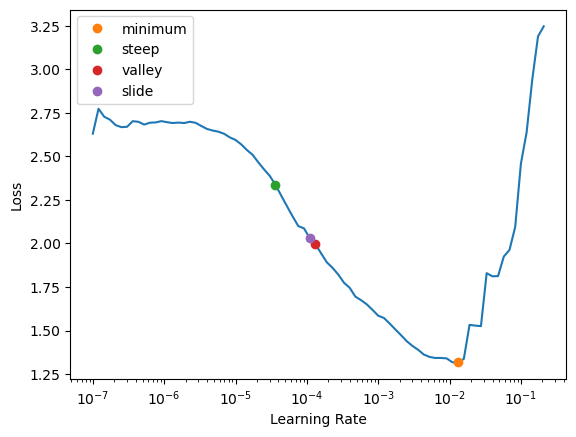

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.3537665009498596
valid_loss 0.36438706517219543
accuracy 0.41006308794021606


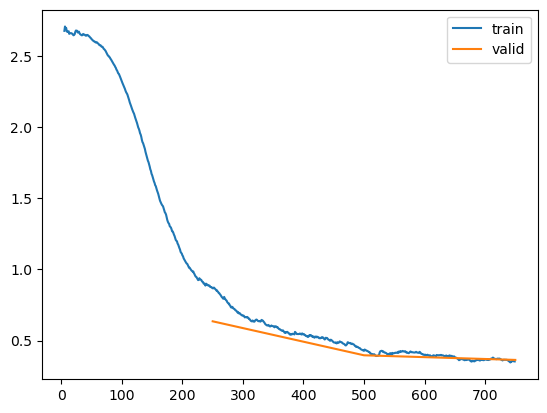

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Hugging Face

#### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	9

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#### Step 2: `Datasets` (huggingface)

In [ ]:
print("Train|Validation examples: ", len(train_ds), len(valid_ds))

print(train_ds[:2])
print("")
print(train_ds["tokens"][:2])

Train|Validation examples:  1000 200
{'id': ['2797', '9139'], 'tokens': [['Ecuador', "'s", 'President', 'Abdala', 'Bucaram', 'has', 'announced', 'he', 'will', 'hold', 'regular', 'lunches', 'in', 'his', 'presidential', 'palace', 'for', 'members', 'of', 'the', 'country', "'s", 'different', 'ethnic', 'groups', 'as', 'of', 'next', 'week', '.'], ['--', 'Fatima', 'Cristina', ',', 'Sao', 'Paulo', 'newsroom', ',', '55-11-2324411']], 'pos_tags': [[22, 27, 22, 22, 22, 42, 40, 28, 20, 37, 16, 24, 15, 29, 16, 21, 15, 24, 15, 12, 21, 27, 16, 16, 24, 15, 15, 16, 21, 7], [8, 22, 22, 6, 22, 22, 21, 6, 11]], 'chunk_tags': [[11, 11, 12, 12, 12, 21, 22, 11, 21, 22, 11, 12, 13, 11, 12, 12, 13, 11, 13, 11, 12, 11, 12, 12, 12, 13, 14, 11, 12, 0], [0, 11, 12, 0, 11, 12, 12, 0, 11]], 'ner_tags': [[5, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 2, 0, 5, 6, 0, 0, 0]], 'is_valid': [False, False]}

[['Ecuador', "'s", 'President', 'Abdala', 'Bucaram', 'has', 'anno

In [ ]:
# define our subword tokenized labeling strategy
labeling_strat = BILabelingStrategy(hf_tokenizer=hf_tokenizer, label_names=label_names)

# tokenize the dataset
def tokenize_func(examples):
    inputs = hf_tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = inputs.word_ids(i)
        new_labels.append(labeling_strat.align_labels_with_tokens(word_ids, labels))

    inputs["label"] = new_labels
    return inputs


proc_train_ds = train_ds.map(tokenize_func, batched=True, remove_columns=train_ds.column_names)
proc_valid_ds = valid_ds.map(tokenize_func, batched=True, remove_columns=valid_ds.column_names)

print(proc_train_ds)
print(proc_valid_ds)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-5a6347645eb78853.arrow


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 1000
})
Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 200
})


##### Step 3: `DataLoaders` (PyTorch)

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TokenClassTextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(proc_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(proc_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

#### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


#### Step 5: Train

SuggestedLRs(minimum=0.001096478197723627, steep=3.630780702224001e-05, valley=0.00010964782268274575, slide=0.00010964782268274575)

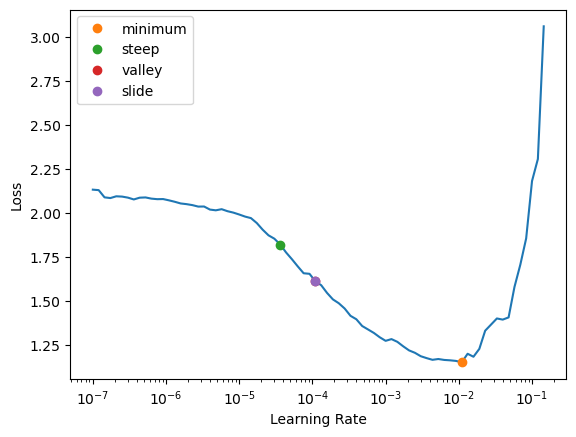

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.33747598528862
valid_loss 0.3475481867790222
accuracy 0.40650254487991333


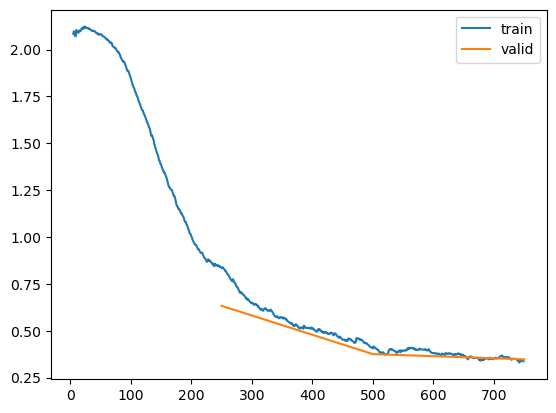

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Low-Level API

In this section, we include a custom `show_results()` method that will work with fast.ai's low-level and mid-level (think `DataBlock`) APIs.

In [ ]:
# |export
def calculate_token_class_metrics(pred_toks, targ_toks, metric_key):
    if metric_key == "accuracy":
        return seq_metrics.accuracy_score(targ_toks, pred_toks)

    if metric_key == "precision":
        return seq_metrics.precision_score(targ_toks, pred_toks)

    if metric_key == "recall":
        return seq_metrics.recall_score(targ_toks, pred_toks)

    if metric_key == "f1":
        return seq_metrics.f1_score(targ_toks, pred_toks)

    if metric_key == "classification_report":
        return seq_metrics.classification_report(targ_toks, pred_toks)

In [ ]:
nbdev.show_doc(calculate_token_class_metrics, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/training/token_classification.py#L50){target="_blank" style="float:right; font-size:smaller"}

### calculate_token_class_metrics

>      calculate_token_class_metrics (pred_toks, targ_toks, metric_key)

### `TokenClassMetricsCallback` -

In [ ]:
# |export
class TokenClassMetricsCallback(Callback):
    """
    A fastai friendly callback that includes accuracy, precision, recall, and f1 metrics using the
    `seqeval` library.  Additionally, this metric knows how to *not* include your 'ignore_token' in it's
    calculations.

    See [here](https://github.com/chakki-works/seqeval) for more information on `seqeval`.
    """

    def __init__(self, tok_metrics=["accuracy", "precision", "recall", "f1"], **kwargs):
        self.run_before = Recorder

        store_attr(self=self, names="tok_metrics, kwargs")
        self.custom_metrics_dict = {k: None for k in tok_metrics}

        self.do_setup = True

    def setup(self):
        # one time setup code here.
        if not self.do_setup:
            return

        # grab the hf_tokenizer from the TokenClassBatchTokenizeTransform
        tfm = first_blurr_tfm(self.learn.dls)
        self.hf_tokenizer = tfm.hf_tokenizer
        self.ignore_label_token_id = tfm.ignore_token_id
        self.tok_special_symbols = list(self.hf_tokenizer.special_tokens_map.values())
        self.tok_kwargs = tfm.kwargs

        # grab our label names
        self.trg_labels = tfm.kwargs["label_names"] if ("label_names" in tfm.kwargs) else None
        if self.trg_labels is None and self.learn.dls.vocab is not None:
            self.trg_labels = self.learn.dls.vocab

        # add custom text generation specific metrics
        custom_metric_keys = self.custom_metrics_dict.keys()
        custom_metrics = L([ValueMetric(partial(self.metric_value, metric_key=k), k) for k in custom_metric_keys])
        self.learn.metrics = self.learn.metrics + custom_metrics
        self.learn.token_classification_report = None

        self.do_setup = False

    def before_fit(self):
        self.setup()

    # --- batch begin/after phases ---
    def before_batch(self):
        pass

    def after_batch(self):
        if self.training or self.learn.y is None:
            return

        # do this only for validation set
        preds = self.pred.argmax(dim=-1)
        targs = self.yb[0]  # yb is TensorText tuple, item 0 is the data

        preds_list, targets_list = [], []
        for i in range(targs.shape[0]):
            item_targs, item_preds = [], []

            for j in range(targs.shape[1]):
                if targs[i, j] != self.ignore_label_token_id:
                    item_preds.append(self.trg_labels[preds[i][j].item()])
                    item_targs.append(self.trg_labels[targs[i][j].item()])

            preds_list.append(item_preds)
            targets_list.append(item_targs)

        self.results += [(res[0], res[1]) for res in zip(preds_list, targets_list)]

    # --- validation begin/after phases ---
    def before_validate(self):
        self.results = []

    def after_validate(self):
        if len(self.results) < 1:
            return

        preds, targs = map(list, zip(*self.results))
        for k in self.custom_metrics_dict.keys():
            self.custom_metrics_dict[k] = calculate_token_class_metrics(targs, preds, metric_key=k)

        try:
            self.learn.token_classification_report = calculate_token_class_metrics(targs, preds, "classification_report")
        except ZeroDivisionError as err:
            print(f"Couldn't calcualte classification report: {err}")

    # --- for ValueMetric metrics ---
    def metric_value(self, metric_key):
        return self.custom_metrics_dict[metric_key]

### `show_results` -

In [ ]:
# |export
@typedispatch
def show_results(
    # This typedispatched `show_results` will be called for `TextInput` typed inputs
    x: TokenClassTextInput,
    # Your targets
    y,
    # Your raw inputs/targets
    samples,
    # The model's predictions
    outs,
    # Your `Learner`. This is required so as to get at the Hugging Face objects for decoding them into
    # something understandable
    learner,
    # Your `show_results` context
    ctxs=None,
    # The maximum number of items to show
    max_n=6,
    # Any truncation your want applied to your decoded inputs
    trunc_at=None,
    # Any other keyword arguments you want applied to `show_results`
    **kwargs,
):
    # grab our tokenizer
    tfm = first_blurr_tfm(learner.dls)
    hf_arch, hf_tokenizer = tfm.hf_arch, tfm.hf_tokenizer

    # if we've included our labels list, we'll use it to look up the value of our target(s)
    trg_labels = tfm.kwargs["label_names"] if ("label_names" in tfm.kwargs) else None
    if trg_labels is None and learner.dls.vocab is not None:
        trg_labels = learner.dls.vocab

    res = L()
    n_inp = learner.dls.n_inp

    n_samples = min(max_n, learner.dls.bs)
    for idx in range(n_samples):
        input_ids = x[idx]
        trgs = y[idx]
        pred = outs[idx]
        sample = samples[idx] if samples is not None else None

        # align "tokens" with labels
        tok_labels = get_token_labels_from_input_ids(hf_tokenizer, input_ids, trgs, trg_labels)
        # align "words" with labels
        word_labels = get_word_labels_from_token_labels(hf_arch, hf_tokenizer, tok_labels)
        # align "words" with "predicted" labels
        if isinstance(pred[0], str):
            pred_labels = ast.literal_eval(pred[0])
        elif torch.is_tensor(pred[0]):
            pred_labels = [trg_labels[label_id] for label_id in list(pred[0].numpy())]

        word_pred_labels = [pred_lbl for lbl_id, pred_lbl in zip(trgs, pred_labels) if lbl_id != -100]
        # stringify list of (word,label) for example
        res.append(
            [
                f"{[ (word_targ[0], word_targ[1], pred_targ) for idx, (word_targ, pred_targ) in enumerate(zip(word_labels, word_pred_labels)) if (trunc_at is None or idx < trunc_at) ]}"
            ]
        )

    display_df(pd.DataFrame(res, columns=["token / target label / predicted label"])[:max_n])
    return ctxs

## Low-Level API: Examples

### Using fast.ai `Datasets` and `DataLoaders`

#### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	9

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#### Step 2: `Datasets` (fastai)

In [ ]:
# define our subword tokenized labeling strategy
labeling_strat = BILabelingStrategy(hf_tokenizer=hf_tokenizer, label_names=label_names)

# tokenize the dataset
def tokenize_func(examples):
    inputs = hf_tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = inputs.word_ids(i)
        new_labels.append(labeling_strat.align_labels_with_tokens(word_ids, labels))

    inputs["label"] = new_labels
    return inputs


proc_conll2003_ds = conll2003_ds.map(tokenize_func, batched=True)

# turn Arrow into DataFrame (`ColSplitter` only works with `DataFrame`s)
train_df = pd.DataFrame(proc_conll2003_ds)
train_df.head()

# define dataset splitter
splitter = ColSplitter("is_valid")
splits = splitter(train_df)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=train_df, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [ ]:
print("Items in train|validation datasets: ", len(dsets.train), len(dsets.valid))

example = dsets.valid[0]
# example

print(f"Items in each example: {len(example)}")
print(f"Example inputs: {list(example[0].keys())}")
print(f"Example target(s): {example[1]}")

Items in train|validation datasets:  1000 200
Items in each example: 2
Example inputs: ['input_ids', 'token_type_ids', 'attention_mask']
Example target(s): [-100, 3, 0, 0, 0, 0, 0, 0, 0, -100]


#### Step 3: `DataLoaders` (fastai)

In [ ]:
data_collator = TokenClassTextCollatorWithPadding(hf_tokenizer)
sort_func = partial(sorted_dl_func, hf_tokenizer=hf_tokenizer)

dls = dsets.dataloaders(
    batch_size=4,
    create_batch=data_collator,
    dl_type=partial(SortedDL, sort_func=sort_func),
)

In [ ]:
print(len(dls.train), len(dls.valid))

b = next(iter(dls.train))
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

# b

250 50
2

[CLS] MARKET TALK - USDA net change in weekly export commitments for the week ended August 22, includes old crop and new crop, were : wheat up 595,400 tonnes old, nil new ; corn up 1,900 old, up 319,600 new ; soybeans down 12,300 old, up 300,800 new ; upland cotton up 50,400 bales new, nil old ; soymeal 54,800 old, up 100,600 new, soyoil nil old, up 75,000 new ; barley up 1,700 old, nil new ; sorghum 6,200 old, up 156,700 new ; pima cotton up 4,000 bales old, nil new ; rice up 49,900 old, nil new...[SEP]

tensor([[-100,    0,    0,    0,    3,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,

#### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 148)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 148 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 148 x 3072      
Linear                         

#### Step 5: Train

SuggestedLRs(minimum=0.0007585775572806596, steep=3.630780702224001e-05, valley=0.0005754399462603033, slide=0.002511886414140463)

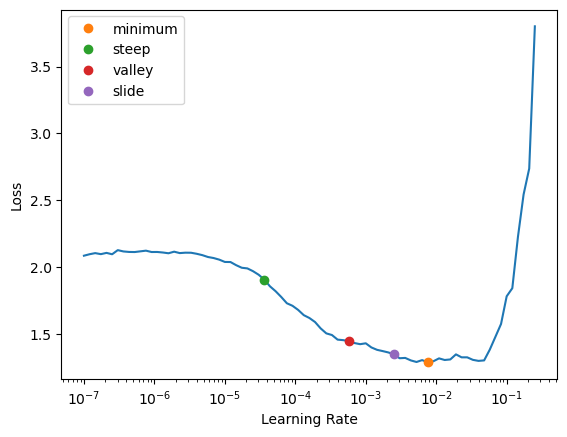

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.4514875113964081
valid_loss 0.3824586570262909
accuracy 0.48556095361709595


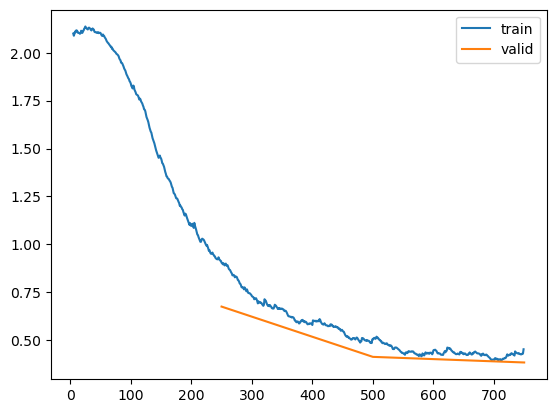

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.export("../models/test_text_tokclass_low_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Using `BatchDecodeTransform` and `TextDataLoader`

#### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	9

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#### Step 2: `Datasets` (fastai)

In [ ]:
# define our subword tokenized labeling strategy
labeling_strat = BILabelingStrategy(hf_tokenizer=hf_tokenizer, label_names=label_names)

# tokenize the dataset
def tokenize_func(examples):
    inputs = hf_tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = inputs.word_ids(i)
        new_labels.append(labeling_strat.align_labels_with_tokens(word_ids, labels))

    inputs["label"] = new_labels
    return inputs


proc_conll2003_ds = conll2003_ds.map(tokenize_func, batched=True)

# define dataset splitter
def _split_func(example):
    return example["is_valid"] == True


splitter = FuncSplitter(_split_func)
splits = splitter(proc_conll2003_ds)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=proc_conll2003_ds, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-b6f8b60af234da8d.arrow


#### Step 3: `DataLoaders` (fastai)

In [ ]:
batch_size = 4

trn_dl = TextDataLoader(
    dsets.train,
    hf_tokenizer,
    text_collator=TokenClassTextCollatorWithPadding(hf_tokenizer=hf_tokenizer),
    batch_decode_kwargs={"label_names": label_names},
    input_return_type=TokenClassTextInput,
    shuffle=True,
    batch_size=batch_size,
)

val_dl = TextDataLoader(
    dsets.valid,
    hf_tokenizer,
    text_collator=TokenClassTextCollatorWithPadding(hf_tokenizer=hf_tokenizer),
    input_return_type=TokenClassTextInput,
    batch_decode_kwargs={"label_names": label_names},
    batch_size=batch_size * 2,
)

dls = DataLoaders(trn_dl, val_dl)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2)

,word / target label
0,"[('The', 'O'), ('latest', 'O'), ('indicators', 'O'), (':', 'O')]"
1,"[('Moin', 'B-PER'), ('Khan', 'I-PER'), ('b', 'O'), ('Salisbury', 'B-PER'), ('23', 'O')]"


#### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=CrossEntropyLossFlat(),
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 23)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 23 x 768        
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 23 x 3072       
Linear                          

#### Step 5: Train

SuggestedLRs(minimum=0.0013182567432522773, steep=1.737800812406931e-05, valley=0.00013182566908653826, slide=0.004365158267319202)

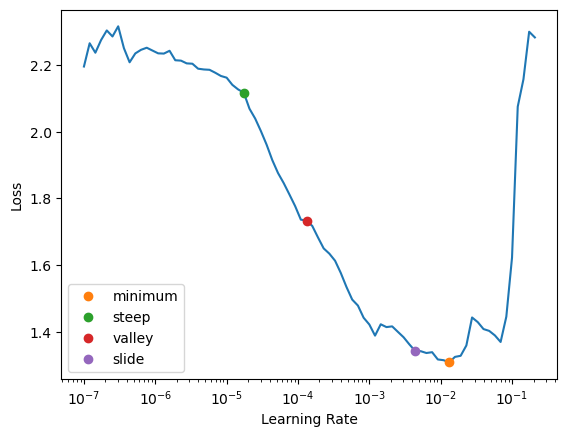

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5), cbs=[TokenClassMetricsCallback()])

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.36582738161087036
valid_loss 0.3498472571372986
accuracy 0.8949489521762494
precision 0.41952506596306066
recall 0.5031645569620253
f1 0.45755395683453237


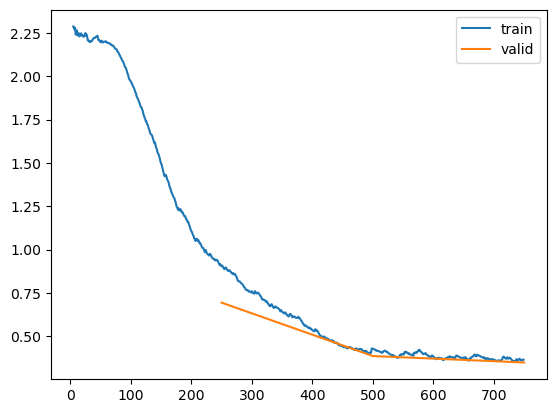

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,token / target label / predicted label
0,"[('Wigan', 'B-ORG', 'B-ORG'), ('4', 'O', 'O'), ('Chester', 'B-ORG', 'B-ORG'), ('2', 'O', 'O')]"
1,"[('NEW', 'B-LOC', 'B-LOC'), ('YORK', 'I-LOC', 'B-LOC'), ('1996-08-30', 'O', 'O')]"


In [ ]:
learn.export("../models/test_text_tokclass_low_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Mid-Level API

Everything required to train transformers using the mid-level API is already there, so lets move straight to the examples

## Mid-Level API: Examples

### Pretokenized

#### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	9

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


####  Step 2: `DataBlock`

In [ ]:
# define DataBlock splitter
def _split_func(example):
    return example["is_valid"] == True


splitter = FuncSplitter(_split_func)


# define how we want to build our targets
# note: we don't need to define how to build our inputs because we're using an HF `Dataset` in this example
def get_y(example):
    return example["label"]


# define the DataBlock
data_collator = TokenClassTextCollatorWithPadding(hf_tokenizer)

txt_block = TextBlock(
    hf_arch=hf_arch,
    hf_config=hf_config,
    hf_tokenizer=hf_tokenizer,
    hf_model=hf_model,
    input_return_type=TokenClassTextInput,
    data_collator=data_collator,
    batch_decode_kwargs={"label_names": label_names},
)

blocks = (txt_block, noop)
dblock = DataBlock(blocks=blocks, get_y=get_y, splitter=splitter)

#### Step 3: `DataLoaders`

In [ ]:
# define our subword tokenized labeling strategy
labeling_strat = BILabelingStrategy(hf_tokenizer=hf_tokenizer, label_names=label_names)

# tokenize the dataset
def tokenize_func(examples):
    inputs = hf_tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = inputs.word_ids(i)
        new_labels.append(labeling_strat.align_labels_with_tokens(word_ids, labels))

    inputs["label"] = new_labels
    return inputs


proc_conll2003_ds = conll2003_ds.map(tokenize_func, batched=True)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-b6f8b60af234da8d.arrow


In [ ]:
dls = dblock.dataloaders(proc_conll2003_ds, bs=4)

Let's take a look at the actual types represented by our batch

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,word / target label
0,"[('MARKET', 'O'), ('TALK', 'O'), ('-', 'O'), ('USDA', 'B-ORG'), ('net', 'O'), ('change', 'O'), ('in', 'O'), ('weekly', 'O'), ('export', 'O'), ('commitments', 'O'), ('for', 'O'), ('the', 'O'), ('week', 'O'), ('ended', 'O'), ('August', 'O'), ('22', 'O'), (',', 'O'), ('includes', 'O'), ('old', 'O'), ('crop', 'O'), ('and', 'O'), ('new', 'O'), ('crop', 'O'), (',', 'O'), ('were', 'O'), (':', 'O'), ('wheat', 'O'), ('up', 'O'), ('595,400', 'O'), ('tonnes', 'O'), ('old', 'O'), (',', 'O'), ('nil', 'O'), ('new', 'O'), (';', 'O'), ('corn', 'O'), ('up', 'O'), ('1,900', 'O'), ('old', 'O'), (',', 'O'), ('up', 'O'), ('319,600', 'O'), ('new', 'O'), (';', 'O'), ('soybeans', 'O'), ('down', 'O'), ('12,300', 'O'), ('old', 'O'), (',', 'O'), ('up', 'O'), ('300,800', 'O'), ('new', 'O'), (';', 'O'), ('upland', 'O'), ('cotton', 'O'), ('up', 'O'), ('50,400', 'O'), ('bales', 'O'), ('new', 'O'), (',', 'O'), ('nil', 'O'), ('old', 'O'), (';', 'O'), ('soymeal', 'O'), ('54,800', 'O'), ('old', 'O'), (',', 'O'), ('up', 'O'), ('100,600', 'O'), ('new', 'O'), (',', 'O'), ('soyoil', 'O'), ('nil', 'O'), ('old', 'O'), (',', 'O'), ('up', 'O'), ('75,000', 'O'), ('new', 'O'), (';', 'O'), ('barley', 'O'), ('up', 'O'), ('1,700', 'O'), ('old', 'O'), (',', 'O'), ('nil', 'O'), ('new', 'O'), (';', 'O'), ('sorghum', 'O'), ('6,200', 'O'), ('old', 'O'), (',', 'O'), ('up', 'O'), ('156,700', 'O'), ('new', 'O'), (';', 'O'), ('pima', 'O'), ('cotton', 'O'), ('up', 'O'), ('4,000', 'O'), ('bales', 'O'), ('old', 'O'), (',', 'O'), ('nil', 'O'), ('new', 'O'), (';', 'O'), ('rice', 'O'), ('up', 'O'), ('49,900', 'O'), ('old', 'O'), (',', 'O'), ('nil', 'O'), ('new', 'O'), ('...', 'O')]"
1,"[('The', 'O'), ('fourth-seeded', 'O'), ('Spaniard', 'B-MISC'), (',', 'O'), ('who', 'O'), ('is', 'O'), ('tackling', 'O'), ('the', 'O'), ('world', 'O'), ('class', 'O'), ('traffic', 'O'), ('of', 'O'), ('New', 'B-LOC'), ('York', 'I-LOC'), ('City', 'I-LOC'), ('as', 'O'), ('a', 'O'), ('warm-up', 'O'), ('by', 'O'), ('driving', 'O'), ('to', 'O'), ('the', 'O'), ('tennis', 'O'), ('centre', 'O'), ('for', 'O'), ('her', 'O'), ('matches', 'O'), (',', 'O'), ('ran', 'O'), ('over', 'O'), ('France', 'B-LOC'), (""'s"", 'O'), ('Nathalie', 'B-PER'), ('Tauziat', 'I-PER'), ('6-1', 'O'), ('6-3', 'O'), ('on', 'O'), ('Wednesday', 'O'), ('to', 'O'), ('take', 'O'), ('her', 'O'), ('place', 'O'), ('in', 'O'), ('the', 'O'), ('third', 'O'), ('round', 'O'), ('.', 'O')]"


#### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=CrossEntropyLossFlat(),
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 148)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 148 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 148 x 3072      
Linear                         

#### Step 5: Train

SuggestedLRs(minimum=0.0003019951749593019, steep=3.630780702224001e-05, valley=6.30957365501672e-05, slide=0.00019054606673307717)

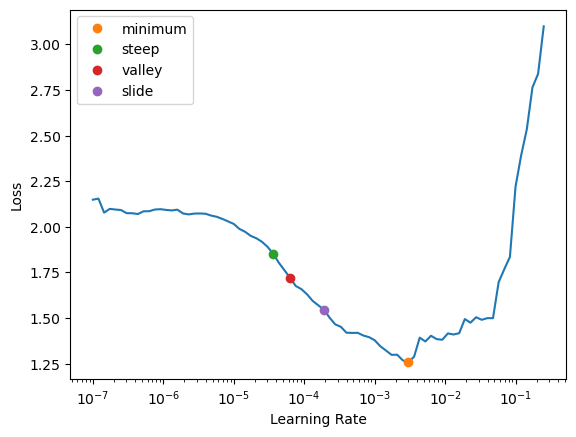

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5), cbs=[TokenClassMetricsCallback()])

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.44989466667175293
valid_loss 0.39600035548210144
accuracy 0.8882321332616873
precision 0.41952506596306066
recall 0.5247524752475248
f1 0.4662756598240469


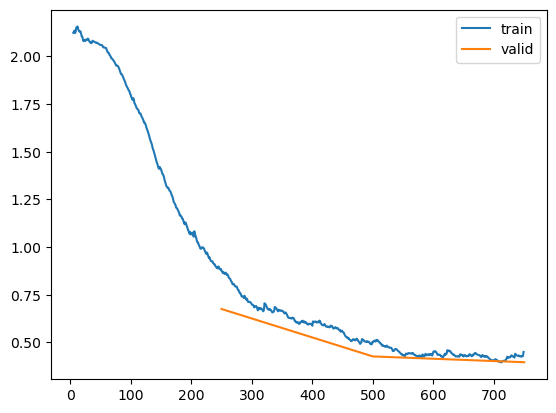

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,token / target label / predicted label
0,"[('Ipswich', 'B-ORG', 'B-ORG'), ('4', 'O', 'O'), ('1', 'O', 'O'), ('2', 'O', 'O'), ('1', 'O', 'O'), ('9', 'O', 'O'), ('7', 'O', 'O'), ('5', 'O', 'O')]"
1,"[('2.', 'O', 'O'), ('Yoelvis', 'B-PER', 'O'), ('Quesada', 'I-PER', 'I-PER'), ('(', 'O', 'I-PER'), ('Cuba', 'B-LOC', 'I-PER'), (')', 'O', 'I-PER'), ('17.44', 'O', 'O')]"


In [ ]:
learn.export("../models/test_text_tokclass_low_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Batch-Time Tokenization

#### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	9

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


####  Step 2: `DataBlock`

In [ ]:
tokenize_tfm = TokenClassBatchTokenizeTransform(
    hf_arch, hf_config, hf_tokenizer, hf_model, labeling_strategy_cls=BILabelingStrategy, target_label_names=label_names
)

blocks = (TextBlock(tokenize_tfm=tokenize_tfm, input_return_type=TokenClassTextInput), TokenCategoryBlock(vocab=label_names))
dblock = DataBlock(
    blocks=blocks,
    get_x=ColReader("tokens"),
    get_y=ColReader("ner_tags"),
    splitter=ColSplitter(),
)

In [ ]:
# |hide
# dblock.summary(conll2003_df)

#### Step 3: `DataLoaders`

In [ ]:
dls = dblock.dataloaders(conll2003_df, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,word / target label
0,"[('MARKET', 'O'), ('TALK', 'O'), ('-', 'O'), ('USDA', 'B-ORG'), ('net', 'O'), ('change', 'O'), ('in', 'O'), ('weekly', 'O'), ('export', 'O'), ('commitments', 'O'), ('for', 'O'), ('the', 'O'), ('week', 'O'), ('ended', 'O'), ('August', 'O'), ('22', 'O'), (',', 'O'), ('includes', 'O'), ('old', 'O'), ('crop', 'O'), ('and', 'O'), ('new', 'O'), ('crop', 'O'), (',', 'O'), ('were', 'O'), (':', 'O'), ('wheat', 'O'), ('up', 'O'), ('595,400', 'O'), ('tonnes', 'O'), ('old', 'O'), (',', 'O'), ('nil', 'O'), ('new', 'O'), (';', 'O'), ('corn', 'O'), ('up', 'O'), ('1,900', 'O'), ('old', 'O'), (',', 'O'), ('up', 'O'), ('319,600', 'O'), ('new', 'O'), (';', 'O'), ('soybeans', 'O'), ('down', 'O'), ('12,300', 'O'), ('old', 'O'), (',', 'O'), ('up', 'O'), ('300,800', 'O'), ('new', 'O'), (';', 'O'), ('upland', 'O'), ('cotton', 'O'), ('up', 'O'), ('50,400', 'O'), ('bales', 'O'), ('new', 'O'), (',', 'O'), ('nil', 'O'), ('old', 'O'), (';', 'O'), ('soymeal', 'O'), ('54,800', 'O'), ('old', 'O'), (',', 'O'), ('up', 'O'), ('100,600', 'O'), ('new', 'O'), (',', 'O'), ('soyoil', 'O'), ('nil', 'O'), ('old', 'O'), (',', 'O'), ('up', 'O'), ('75,000', 'O'), ('new', 'O'), (';', 'O'), ('barley', 'O'), ('up', 'O'), ('1,700', 'O'), ('old', 'O'), (',', 'O'), ('nil', 'O'), ('new', 'O'), (';', 'O'), ('sorghum', 'O'), ('6,200', 'O'), ('old', 'O'), (',', 'O'), ('up', 'O'), ('156,700', 'O'), ('new', 'O'), (';', 'O'), ('pima', 'O'), ('cotton', 'O'), ('up', 'O'), ('4,000', 'O'), ('bales', 'O'), ('old', 'O'), (',', 'O'), ('nil', 'O'), ('new', 'O'), (';', 'O'), ('rice', 'O'), ('up', 'O'), ('49,900', 'O'), ('old', 'O'), (',', 'O'), ('nil', 'O'), ('new', 'O'), ('...', 'O')]"
1,"[('In', 'O'), ('his', 'O'), ('opinion', 'O'), ('the', 'O'), ('quartering', 'O'), ('of', 'O'), ('Unita', 'B-ORG'), ('forces', 'O'), ('must', 'O'), ('be', 'O'), ('concluded', 'O'), ('in', 'O'), ('all', 'O'), ('the', 'O'), ('Angolan', 'B-MISC'), ('territory', 'O'), ('and', 'O'), ('the', 'O'), ('troops', 'O'), ('must', 'O'), ('be', 'O'), ('selected', 'O'), ('and', 'O'), ('integrated', 'O'), ('in', 'O'), ('the', 'O'), ('armed', 'O'), ('forces', 'O'), (',', 'O'), ('the', 'O'), ('government', 'O'), ('forces', 'O'), ('must', 'O'), ('be', 'O'), ('concentrated', 'O'), ('in', 'O'), ('the', 'O'), ('principal', 'O'), ('units', 'O'), ('and', 'O'), ('the', 'O'), ('free', 'O'), ('circulation', 'O'), ('of', 'O'), ('people', 'O'), ('and', 'O'), ('goods', 'O'), ('must', 'O'), ('be', 'O'), ('reality', 'O'), ('in', 'O'), ('all', 'O'), ('the', 'O'), ('country', 'O'), ('.', 'O')]"


#### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=CrossEntropyLossFlat(),
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 148)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 148 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 148 x 3072      
Linear                         

#### Step 5: Train

SuggestedLRs(minimum=0.00020892962347716094, steep=6.30957365501672e-05, valley=4.365158383734524e-05, slide=0.0030199517495930195)

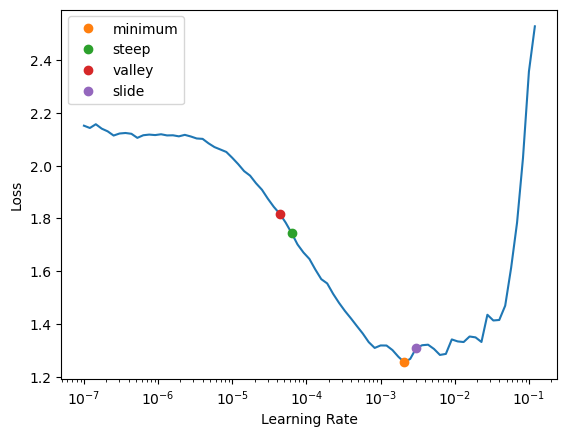

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5), cbs=[TokenClassMetricsCallback()])

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.4365139305591583
valid_loss 0.4249478280544281
accuracy 0.8903815153143472
precision 0.42744063324538256
recall 0.5276872964169381
f1 0.4723032069970845


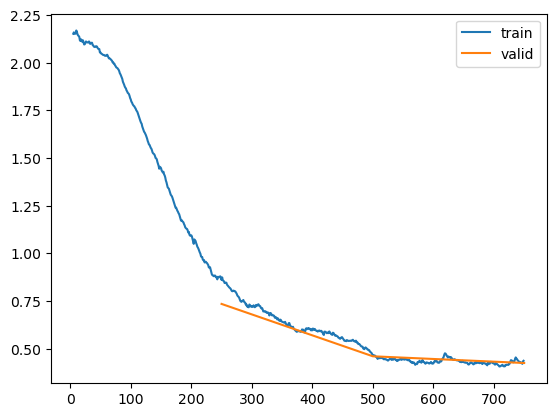

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,token / target label / predicted label
0,"[('A', 'O', 'O'), ('20-ton', 'O', 'O'), ('piece', 'O', 'O'), ('of', 'O', 'O'), ('the', 'O', 'O'), ('Titanic', 'B-MISC', 'O'), (""'s"", 'O', 'O'), ('steel', 'O', 'B-ORG'), ('hull', 'O', 'O'), (',', 'O', 'O'), ('which', 'O', 'O'), ('had', 'O', 'O'), ('been', 'O', 'O'), ('attached', 'O', 'O'), ('by', 'O', 'O'), ('cables', 'O', 'O'), ('to', 'O', 'O'), ('a', 'O', 'O'), ('recovery', 'O', 'O'), ('ship', 'O', 'O'), ('off', 'O', 'O'), ('the', 'O', 'O'), ('coast', 'O', 'O'), ('of', 'O', 'O'), ('Newfoundland', 'B-LOC', 'O'), (',', 'O', 'O'), ('Canada', 'B-LOC', 'O'), (',', 'O', 'B-LOC'), ('fell', 'O', 'O'), ('back', 'O', 'O'), ('to', 'O', 'O'), ('the', 'O', 'O'), ('bottom', 'O', 'O'), ('of', 'O', 'O'), ('the', 'O', 'O'), ('sea', 'O', 'O'), (',', 'O', 'O'), ('said', 'O', 'O'), ('Erin', 'B-PER', 'O'), ('Purcell', 'I-PER', 'O'), ('of', 'O', 'O'), ('Boston-based', 'B-MISC', 'B-PER'), ('Reagan', 'B-ORG', 'I-PER'), ('Communications', 'I-ORG', 'O'), ('that', 'O', 'O'), ('represents', 'O', 'O'), ('two', 'O', 'O'), ('of', 'O', 'B-ORG'), ('the', 'O', 'O'), ('ships', 'O', 'O'), ('used', 'O', 'O'), ('in', 'O', 'O'), ('the', 'O', 'O'), ('expedition', 'O', 'O'), ('.', 'O', 'O')]"
1,"[('Japanese', 'B-MISC', 'O'), ('Goverment', 'I-MISC', 'O'), ('Bonds', 'I-MISC', 'I-ORG'), ('futures', 'O', 'O'), ('which', 'O', 'O'), ('closed', 'O', 'O'), ('before', 'O', 'O'), ('the', 'O', 'O'), ('output', 'O', 'O'), ('data', 'O', 'O'), (',', 'O', 'O'), ('lost', 'O', 'O'), ('much', 'O', 'O'), ('of', 'O', 'O'), ('day', 'O', 'O'), (""'s"", 'O', 'O'), ('gains', 'O', 'O'), ('as', 'O', 'O'), ('Tokyo', 'B-LOC', 'O'), ('stock', 'O', 'O'), ('prices', 'O', 'O'), ('recovered', 'O', 'O'), ('from', 'O', 'O'), ('the', 'O', 'O'), ('day', 'O', 'O'), (""'s"", 'O', 'O'), ('low.In', 'O', 'O'), ('after', 'O', 'O'), ('hours', 'O', 'O'), ('trading', 'O', 'O'), ('the', 'O', 'O'), ('September', 'O', 'O'), ('future', 'O', 'O'), ('on', 'O', 'O'), ('LIFFE', 'B-ORG', 'O'), ('was', 'O', 'O'), ('trading', 'O', 'O'), ('at', 'O', 'O'), ('122.53', 'O', 'O'), (',', 'O', 'B-ORG'), ('up', 'O', 'I-ORG'), ('0.26', 'O', 'O'), ('from', 'O', 'O'), ('Thursday', 'O', 'O'), (""'s"", 'O', 'O'), ('settlement', 'O', 'O'), ('price', 'O', 'O'), ('on', 'O', 'O'), ('the', 'O', 'O'), ('Tokyo', 'B-ORG', 'O'), ('Stock', 'I-ORG', 'O'), ('Exchange', 'I-ORG', 'O'), ('.', 'O', 'O')]"


In [ ]:
learn.export("../models/test_text_tokclass_low_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Item-Time Tokenization

#### Step 1: HF objects.

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	9

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


####  Step 2: `DataBlock`

In [ ]:
tfm = ItemTokenizeTransform(hf_config=hf_config, hf_tokenizer=hf_tokenizer, tok_kwargs={"is_split_into_words": True})
tfm.split_idx = 0

tfm2 = ItemTokenizeTransform(hf_config=hf_config, hf_tokenizer=hf_tokenizer, tok_kwargs={"is_split_into_words": True})
tfm2.split_idx = 1

blocks = (
    TextBlock(
        hf_arch=hf_arch,
        hf_config=hf_config,
        hf_tokenizer=hf_tokenizer,
        hf_model=hf_model,
        type_tfms=[tfm, tfm2],
        data_collator=TokenClassTextCollatorWithPadding(hf_tokenizer),
        input_return_type=TokenClassTextInput,
    ),
    TokenCategoryBlock(vocab=label_names),
)
dblock = DataBlock(
    blocks=blocks,
    get_x=ColReader("tokens"),
    get_y=ColReader("ner_tags"),
    splitter=ColSplitter(),
)

#### Step 3: `DataLoaders`

In [ ]:
dls = dblock.dataloaders(conll2003_df, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,word / target label
0,"[('MARKET', 'O'), ('TALK', 'O'), ('-', 'B-ORG'), ('USDA', 'O'), ('net', 'O'), ('change', 'O'), ('in', 'O'), ('weekly', 'O'), ('export', 'O'), ('commitments', 'O'), ('for', 'O'), ('the', 'O'), ('week', 'O'), ('ended', 'O'), ('August', 'O'), ('22', 'O'), (',', 'O'), ('includes', 'O'), ('old', 'O'), ('crop', 'O'), ('and', 'O'), ('new', 'O'), ('crop', 'O'), (',', 'O'), ('were', 'O'), (':', 'O'), ('wheat', 'O'), ('up', 'O'), ('595,400', 'O'), ('tonnes', 'O'), ('old', 'O'), (',', 'O'), ('nil', 'O'), ('new', 'O'), (';', 'O'), ('corn', 'O'), ('up', 'O'), ('1,900', 'O'), ('old', 'O'), (',', 'O'), ('up', 'O'), ('319,600', 'O'), ('new', 'O'), (';', 'O'), ('soybeans', 'O'), ('down', 'O'), ('12,300', 'O'), ('old', 'O'), (',', 'O'), ('up', 'O'), ('300,800', 'O'), ('new', 'O'), (';', 'O'), ('upland', 'O'), ('cotton', 'O'), ('up', 'O'), ('50,400', 'O'), ('bales', 'O'), ('new', 'O'), (',', 'O'), ('nil', 'O'), ('old', 'O'), (';', 'O'), ('soymeal', 'O'), ('54,800', 'O'), ('old', 'O'), (',', 'O'), ('up', 'O'), ('100,600', 'O'), ('new', 'O'), (',', 'O'), ('soyoil', 'O'), ('nil', 'O'), ('old', 'O'), (',', 'O'), ('up', 'O'), ('75,000', 'O'), ('new', 'O'), (';', 'O'), ('barley', 'O'), ('up', 'O'), ('1,700', 'O'), ('old', 'O'), (',', 'O'), ('nil', 'O'), ('new', 'O'), (';', 'O'), ('sorghum', 'O'), ('6,200', 'O'), ('old', '[xIGNx]'), (',', '[xIGNx]'), ('up', '[xIGNx]'), ('156,700', '[xIGNx]'), ('new', '[xIGNx]'), (';', '[xIGNx]'), ('pima', '[xIGNx]'), ('cotton', '[xIGNx]'), ('up', '[xIGNx]'), ('4,000', '[xIGNx]'), ('bales', '[xIGNx]'), ('old', '[xIGNx]'), (',', '[xIGNx]'), ('nil', '[xIGNx]'), ('new', '[xIGNx]'), (';', '[xIGNx]'), ('rice', '[xIGNx]'), ('up', '[xIGNx]'), ('49,900', '[xIGNx]'), ('old', '[xIGNx]'), (',', '[xIGNx]'), ('nil', '[xIGNx]'), ('new', '[xIGNx]'), ('...', '[xIGNx]')]"
1,"[('In', 'O'), ('his', 'O'), ('opinion', 'O'), ('the', 'O'), ('quartering', 'O'), ('of', 'O'), ('Unita', 'O'), ('forces', 'O'), ('must', 'O'), ('be', 'O'), ('concluded', 'O'), ('in', 'B-MISC'), ('all', 'O'), ('the', 'O'), ('Angolan', 'O'), ('territory', 'O'), ('and', 'O'), ('the', 'O'), ('troops', 'O'), ('must', 'O'), ('be', 'O'), ('selected', 'O'), ('and', 'O'), ('integrated', 'O'), ('in', 'O'), ('the', 'O'), ('armed', 'O'), ('forces', 'O'), (',', 'O'), ('the', 'O'), ('government', 'O'), ('forces', 'O'), ('must', 'O'), ('be', 'O'), ('concentrated', 'O'), ('in', 'O'), ('the', 'O'), ('principal', 'O'), ('units', 'O'), ('and', 'O'), ('the', 'O'), ('free', 'O'), ('circulation', 'O'), ('of', 'O'), ('people', 'O'), ('and', 'O'), ('goods', 'O'), ('must', 'O'), ('be', 'O'), ('reality', 'O'), ('in', 'O'), ('all', 'O'), ('the', '[xIGNx]'), ('country', '[xIGNx]'), ('.', '[xIGNx]')]"


#### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=CrossEntropyLossFlat(),
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 148)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 148 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 148 x 3072      
Linear                         

#### Step 5: Train

SuggestedLRs(minimum=0.0033113110810518267, steep=3.630780702224001e-05, valley=0.0006918309954926372, slide=0.0010000000474974513)

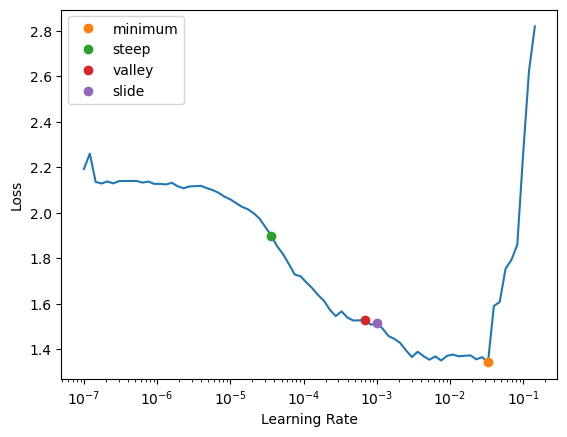

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5), cbs=[TokenClassMetricsCallback()])

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.8028542995452881
valid_loss 0.7486518621444702
accuracy 0.839073262366938
precision 0.029023746701846966
recall 0.8461538461538461
f1 0.05612244897959184


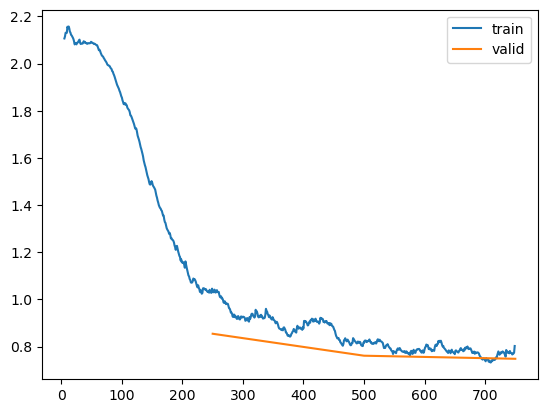

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,token / target label / predicted label
0,"[('Ipswich', 'O', 'O'), ('4', 'O', 'O'), ('1', 'O', 'O'), ('2', 'O', 'O'), ('1', 'O', 'O'), ('9', 'O', 'O'), ('7', 'O', 'O'), ('5', '[xIGNx]', 'O')]"
1,"[('2.', 'B-PER', 'O'), ('Yoelvis', 'O', 'B-PER'), ('Quesada', 'O', 'I-PER'), ('(', '[xIGNx]', 'O'), ('Cuba', '[xIGNx]', 'O'), (')', '[xIGNx]', 'O'), ('17.44', '[xIGNx]', 'O')]"


In [ ]:
learn.export("../models/test_text_tokclass_low_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Tests

The tests below to ensure the core DataBlock code above works for **all** pretrained sequence classification models available in Hugging Face.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained classification models you are working with ... and if any of your pretrained sequence classification models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

## Export -

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()